# vertical profiles of oxygen: shelf vs slope vs open ocean
# maps of oxygen change
# plot drift-corrected files for the future
# plot partial pressure of oxygen
# Fig.S2 in paper

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from matplotlib.patches import Rectangle
import copy
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#------
# MODEL INFO
#------

years = np.arange(1980,2100+1,1)
print (years)

savepath    = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/change_oxygen_with_drift_corr/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)

savepath2    = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/change_oxygen_with_drift_corr/eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]

# get lat/lon/depth
path = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'
which_sim = 'simAssp585'
vari      = 't_insitu'
f1 = Dataset(path+which_sim+'_reduced/'+vari+'_fesom_'+which_sim+'_19950101_v2.nc')
lat_agi = f1.variables['lat'][:]
lon_agi = f1.variables['lon'][:]
zlevs     = f1.variables['depth'][:]
f1.close()


[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]
(72411,)


In [3]:
#-----
# load data for 1990s: oxygen
#-----

vari      = 'pO2'
which_sim = 'simAssp585' # present-day files are in ssp585 folder

path = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'

years = np.arange(1995,2014+1,1)

array_1990s_simA   = np.zeros([len(np.unique(zlevs)),len(lat_agi),len(lon_agi),len(years)]) # only 97 depth levels filled in file
for yy in range(0,len(years)):
    print ('Load '+str(years[yy])+' of '+which_sim)
    
    f1 = Dataset(path+which_sim+'_reduced/'+vari+'_fesom_'+which_sim+'_'+str(years[yy])+'0101_v2.nc')
    data1 = f1.variables[vari][:,:,:] # depth x lat x lon
    f1.close()
    data1 = np.ma.masked_where(data1<-999,data1)
    data1[data1.mask==True]=0
    array_1990s_simA[:,:,:,yy]    = data1
    
    del data1
    
# decadal avg
array_1990s_simA    = np.nanmean(array_1990s_simA,axis=3) 
    
print ('done')


Load 1995 of simAssp585
Load 1996 of simAssp585
Load 1997 of simAssp585
Load 1998 of simAssp585
Load 1999 of simAssp585
Load 2000 of simAssp585
Load 2001 of simAssp585
Load 2002 of simAssp585
Load 2003 of simAssp585
Load 2004 of simAssp585
Load 2005 of simAssp585
Load 2006 of simAssp585
Load 2007 of simAssp585
Load 2008 of simAssp585
Load 2009 of simAssp585
Load 2010 of simAssp585
Load 2011 of simAssp585
Load 2012 of simAssp585
Load 2013 of simAssp585
Load 2014 of simAssp585
done


In [4]:
#-----
# load data for 2090s: temp -> drift-corrected files!
#-----

vari      = 'pO2'

sim_list  = ['ssp585','ssp370','ssp245','ssp126']
sim_list2 = ['simA-ssp585','simA-ssp370','simA-ssp245','simA-ssp126']

# load drift-corrected files 
which_drift = '2091_2100' # 2081_2100, 2091_2100, 2098_2100
drift_corr ='monthly_drift_corrected_'+which_drift+'_minus_1995_2014_v2' 

years = np.arange(int(which_drift[0:4]),int(which_drift[5:])+1,1)

# only 97 depth levels filled in file
array_2090s    = np.zeros([len(np.unique(zlevs)),len(lat_agi),len(lon_agi),len(years),len(sim_list)]) 
for ss in range(0,len(sim_list)):
    
    path = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+sim_list[ss]+'_reduced/'
    
    for yy in range(0,len(years)):
        print ('Load '+str(years[yy])+' of '+sim_list[ss])

        f1 = Dataset(path+vari+'_fesom_'+sim_list[ss]+'_'+str(years[yy])+'0101_'+drift_corr+'.nc')
        data1 = f1.variables[vari][:,:,:] # depth x lat x lon
        f1.close()
        data1 = np.ma.masked_where(data1<-9,data1)
        data1[data1.mask==True]=0
        array_2090s[:,:,:,yy,ss]    = data1
        del data1
    
# decadal avg
array_2090s    = np.nanmean(array_2090s,axis=3)  
    
print ('done')


Load 2091 of ssp585
Load 2092 of ssp585
Load 2093 of ssp585
Load 2094 of ssp585
Load 2095 of ssp585
Load 2096 of ssp585
Load 2097 of ssp585
Load 2098 of ssp585
Load 2099 of ssp585
Load 2100 of ssp585
Load 2091 of ssp370
Load 2092 of ssp370
Load 2093 of ssp370
Load 2094 of ssp370
Load 2095 of ssp370
Load 2096 of ssp370
Load 2097 of ssp370
Load 2098 of ssp370
Load 2099 of ssp370
Load 2100 of ssp370
Load 2091 of ssp245
Load 2092 of ssp245
Load 2093 of ssp245
Load 2094 of ssp245
Load 2095 of ssp245
Load 2096 of ssp245
Load 2097 of ssp245
Load 2098 of ssp245
Load 2099 of ssp245
Load 2100 of ssp245
Load 2091 of ssp126
Load 2092 of ssp126
Load 2093 of ssp126
Load 2094 of ssp126
Load 2095 of ssp126
Load 2096 of ssp126
Load 2097 of ssp126
Load 2098 of ssp126
Load 2099 of ssp126
Load 2100 of ssp126
done


In [5]:
#---
# maps
#---

In [6]:
#-----
# based on python code provided by Anne
#-----
from pathlib import Path
import xarray as xr

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list
habitat_all = np.zeros([360,1440,no_species])

habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!
#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat_tf  = ff['lat'].values 
        lon_tf  = ff['lon'].values 
    ff.close()

    # Get the species name from the full pathname with a space between
    species_names[ifile]  = '_'.join(os.path.basename(file).split('_')[:-2]).replace('_',' ') 
    if not species_names[ifile] in ['Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana']:
        species_names[ifile] = species_names[ifile][8:] # get rid of "Default" or "Reviewed"
    if species_names[ifile][0].isspace():  # get rid of white space if there is any
        species_names[ifile] = species_names[ifile][1:]
    if species_names[ifile] in ['Chionobathyscus dewitti All Suitable Habitat']:
        species_names[ifile] = species_names[ifile][0:23]
    # Get the species name from the full pathname with _ in it
    species_names_[ifile] = species_names[ifile].replace(' ','_')  #'_'.join(os.path.basename(file).split('_')[:-2]) 

#print(habitat_file_names)
print(species_names)
print(len(species_names),'species')
print(species_names_)

# for plotting, set regions outside of habitat to negative number (so that they appear in white)
habitat_all[habitat_all==0] = -999


['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifrons', 'Mesonychoteuthis hamiltoni', 'Pleuragramma antarctica', 'Euphausia superba', 'Notothenia coriiceps', 'Trematomus lepidorhinus', 'Pagothenia borchgrevinki', 'Lycenchelys aratrirostris', 'Neopagetopsis ionah', 'Chaenocephalus aceratus', 'Trematomus hansoni', 'Chionobathyscus dewitti', 'Euphausia crystallorophias', 'Notothenia rossii', 'Bathyraja maccaini']
29 species
['Dissostichus_mawsoni', 'Trematomus_loennbergii', 'Macrourus_whitsoni', 'Galiteuthis_glacialis', 'Chionodraco_hamatus', 'Anotopterus_vorax', 'Chaenodraco_wilsoni', 'Kondakovia_longimana', 'Cryodraco_antarcticus', 'Muraenolepis_microps', 'Psychroteuthis_glacialis'

In [7]:
#----
# define lat/lon -> need to regrid for mapping (topo, cavities)
#----

grid_resolution_x = 0.1  #0.25 # define grid resolution of regular mesh
grid_resolution_y = 0.1 #0.0625
xi = np.arange(-180,180+grid_resolution_x,grid_resolution_x) #longitude
yi = np.arange(-90,40+grid_resolution_y,grid_resolution_y) #latitude

print ('Min/Max lon:',np.min(xi),np.max(xi))
print ('Min/Max lat:',np.min(yi),np.max(yi))
x_all,y_all = np.meshgrid(xi,yi)

lon_agi_all,lat_agi_all = np.meshgrid(lon_agi,lat_agi)

print(x_all.shape)
print(lon_agi_all.shape)


Min/Max lon: -180.0 179.99999999997954
Min/Max lat: -90.0 39.99999999999261
(1301, 3601)
(360, 1440)


In [8]:
#----
# plotting function
#-----
from numpy.ma import masked_array

color_cavity = 'black' #'darkgrey'

dpicnt=200
fs = 12
lw = 1.5 # topography
lw2 = 1.0 # cavity

def plot_map_circumpolar(data_plot,data_tf,lon_plot,lat_plot,lon_tf,lat_tf,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    plot_colorbar = False
    fs = 10
    
    # data to plot
    data_plot1 = np.copy(data_plot)
   
    # projection
    projection=ccrs.SouthPolarStereo()
    
    plot_MPAs = False
    #color_mpa = (200./255.,200./255.,200./255.) #'white' #'black'
    color_mpa = (160./255.,160./255.,160./255.) #'gold' #'white'
    lw_mpa = 2
    
    path1 = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'
    which_res = '0.025'
    f1 = Dataset(path1+'Mask_cavities_regular_mesh_'+which_res+'deg.nc')
    cav_int = f1.variables['mask_cavities'][:]
    f1.close()
    cav_int[cav_int.mask==True]=0
    f1 = Dataset(path1+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
    mask_WAP_MPA = f1.variables['mask_mpa'][:]
    lon_MPA2 = f1.variables['lon'][:]
    lat_MPA2 = f1.variables['lat'][:]
    f1.close()
    lon_MPA,lat_MPA = np.meshgrid(lon_MPA2,lat_MPA2)
    del lon_MPA2,lat_MPA2
    
    if plot_MPAs:

        f1 = Dataset(path1+'MPA_mask_AntarcticPeninsula_regular_mesh_'+which_res+'deg.nc')
        mask_WAP_MPA = f1.variables['mask_mpa'][:]
        lon_MPA2 = f1.variables['lon'][:]
        lat_MPA2 = f1.variables['lat'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_1_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA1_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_2_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA2_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_East_Antarctica_3_regular_mesh_'+which_res+'deg.nc')
        mask_eastAA3_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_Orkney_regular_mesh_'+which_res+'deg.nc')
        mask_Orkney_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_RossSea_regular_mesh_'+which_res+'deg.nc')
        mask_RossSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()
        f1 = Dataset(path1+'MPA_mask_WeddellSea_regular_mesh_'+which_res+'deg.nc')
        mask_WeddellSea_MPA = f1.variables['mask_mpa'][:]
        f1.close()

        mask_eastAA1_MPA[mask_eastAA1_MPA.mask==True]=0 #np.ma.masked_where()
        mask_eastAA2_MPA[mask_eastAA2_MPA.mask==True]=0
        mask_eastAA3_MPA[mask_eastAA3_MPA.mask==True]=0
        mask_WeddellSea_MPA[mask_WeddellSea_MPA.mask==True]=0
        mask_Orkney_MPA[mask_Orkney_MPA.mask==True]=0
        mask_RossSea_MPA[mask_RossSea_MPA.mask==True]=0
        mask_WAP_MPA[mask_WAP_MPA.mask==True]=0
            
        # correct mask so that it matches the mask used on FESOM mesh (see regrid_cavity_to_regular_mesh.ipynb)
        # for the Weddell Sea, connect piece at WAP tip with southern piece
        ind = np.where((lat_MPA<=-64.0) & (lon_MPA<-50) & (lon_MPA>-62.5)) #[0]
        # ind = np.where((lat_MPA<=-64.0) & (lon_MPA<310) & (lon_MPA>298.5)) #[0]
        mask_WeddellSea_MPA[ind]=1
        # correct piece that reaches into WAP
        ind = np.where((lat_MPA>-64.8) & (lon_MPA<-60)) #[0]
        # ind = np.where((lat_MPA >-64.8) & (lon_MPA<300)) #[0]
        mask_WeddellSea_MPA[ind]=0
            
        mask_eastAA1_MPA[cav_int==1]=0
        mask_eastAA2_MPA[cav_int==1]=0
        mask_eastAA3_MPA[cav_int==1]=0
        mask_WeddellSea_MPA[cav_int==1]=0
        mask_Orkney_MPA[cav_int==1]=0
        mask_RossSea_MPA[cav_int==1]=0
        mask_WAP_MPA[cav_int==1]=0
        
        print('min/max mask_MPA:',np.min(mask_WeddellSea_MPA),np.max(mask_WeddellSea_MPA))
        
        
        
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    mm1=ax.contourf(lon_plot, lat_plot, data_plot1,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels(cticks_label)
        
    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-60,-50])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    lw = 2
    ax.contour(lon_plot, lat_plot, topo,levels = [1000],\
                     colors=['dimgrey','black','black'],linewidths=[lw+0.75,lw,lw],\
               linestyles=['-','-',':'],transform=ccrs.PlateCarree())
               
    #-----
    # add MPA contours
    if plot_MPAs:
        #print ('min/max lon_plot:',np.min(lon_plot),np.max(lon_plot))
        #print ('min/max lon_MPA:',np.min(lon_MPA),np.max(lon_MPA))
       
        m = np.zeros_like(mask_RossSea_MPA)
        m[:,0:8] = 1
        m[:,-8:-1] = 1
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        
        m = np.zeros_like(mask_RossSea_MPA)
        m[0:400,:] = 1
        mask_WeddellSea_MPA = np.ma.masked_array(mask_WeddellSea_MPA, m)
        mask_WAP_MPA = np.ma.masked_array(mask_WAP_MPA, m)
        mask_RossSea_MPA = np.ma.masked_array(mask_RossSea_MPA, m)
        mask_eastAA1_MPA = np.ma.masked_array(mask_eastAA1_MPA, m)
        mask_eastAA2_MPA = np.ma.masked_array(mask_eastAA2_MPA, m)
        mask_eastAA3_MPA = np.ma.masked_array(mask_eastAA3_MPA, m)
        mask_Orkney_MPA  = np.ma.masked_array(mask_Orkney_MPA, m)
        
        ax.contour(lon_MPA, lat_MPA, mask_WeddellSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_WAP_MPA,levels = [lw_mpa],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_RossSea_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA1_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA2_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_eastAA3_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        ax.contour(lon_MPA, lat_MPA, mask_Orkney_MPA,levels = [0.5],\
                         colors=[color_mpa],linewidths=[lw_mpa],linestyles=['-'],transform=ccrs.PlateCarree())
        
    ## cavities
    #ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
    #                     colors=['gainsboro'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    # cavities
    ind_2 = np.where(lat_plot[:,0]>-75.0)[0]
    cav_int[0:400,:] = 1 # high-high-latitudes
    ind_s = 420
    cav_int[ind_s:,-5] =  -999
    cav_int[ind_s:,-4] =  -999
    cav_int[ind_s:,-3] =  -999
    cav_int[ind_s:,-2] =  -999
    cav_int[ind_s:,-1] =  -999
    cav_int[ind_s:,0]  =  -999
    cav_int[ind_s:,1]  =  -999
    cav_int[ind_s:,2]  =  -999
    cav_int[ind_s:,3]  =  -999
    cav_int[ind_s:,4]  =  -999
    
    m = np.zeros_like(cav_int)
    m[:,0:10] = 1
    m[:,-10:-1] = 1
    cav_int = np.ma.masked_array(cav_int, m)

    cav_color = (50./255.,50./255.,50./255.)
    #cav_color2 = 'oldlace' 
    cav_color2 = (218./255.,228./255.,238./255.)
    
    ax.contourf(lon_MPA, lat_MPA, cav_int,levels = [0.5,1],\
                         colors=[cav_color2],\
               linewidths=[lw],linestyles=['-'],zorder=50,transform=ccrs.PlateCarree())
    
    ax.contour(lon_MPA, lat_MPA, cav_int,levels = [0.5],\
                         colors=[cav_color],\
               linewidths=[lw],linestyles=['-'],zorder=50,transform=ccrs.PlateCarree())
    
    # toothfish habitat
    #print(data_tf.shape,lon_tf.shape,lat_tf.shape)
    mm1=ax.contour(lon_tf,lat_tf, data_tf,levels=[1],colors=['black'],linewidths=[0.75],linestyles=['-'],\
                   transform=ccrs.PlateCarree())
    
    #colors2 = matplotlib.colors.ListedColormap([(218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.),\
    #                                        (218./255.,228./255.,238./255.),(218./255.,228./255.,238./255.)])
    
    #levels1 = np.arange(0,3,1)
    #mm1=ax.contourf(lon_MPA, lat_MPA, cav_int,\
    #           levels=levels1,extend='both',cmap=colors2,transform=ccrs.PlateCarree())
    # gainsboro
    #-----
    
    #ax.contour(lon_plot, lat_plot, data_plot_ice1,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['-'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice2,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=['--'],transform=ccrs.PlateCarree())
    #ax.contour(lon_plot, lat_plot, data_plot_ice3,levels = [0.15],\
    #                 colors=['black'],linewidths=[lw],linestyles=[':'],transform=ccrs.PlateCarree())

    #ax.annotate('all between '+str(depth1)+'-'+str(depth2)+'m',xy=(0.29,0.012),\
    #            xycoords='axes fraction',style='italic',fontsize=fs,ha='right',color='k') #fontweight='bold'

    dpicnt = 200

    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #return lon_MPA, lat_MPA,cav_int
    
def plot_map_circumpolar_colorbar(data_plot,lon_plot,lat_plot,topo,levels1,cmap1,ctick1,\
                                    cticks_label,clabel_string,depth_label,\
                         save_plots,display_plots,savepath,filename1):
    plot_colorbar = True
    fs = 10
    
    # data to plot
    data_plot1 = np.copy(data_plot)
   
    # projection
    projection=ccrs.SouthPolarStereo()
    
    #---
    # PNG
    #---
    print('Colorbar png...')
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # plot coastal
    #data_plot1 = np.ones_like(lon_plot)
    mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels(cticks_label)

    dpicnt = 200
    if save_plots:
        filename = filename1+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #---
    # EPS
    #---
    print('Colorbar eps...')
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    ax.coastlines(resolution='50m')
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    mm1=ax.contourf(lon_plot, lat_plot, data_plot,\
                   levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    plt.gca().set_visible(False)
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        #cbar.set_label(clabel_string,fontsize=fs+3) #clabel_string
        cbar.ax.tick_params(labelsize=fs+3)
        cbar.ax.set_xticklabels([])#cticks_label)

    dpicnt = 200
    if save_plots:
        filename = filename1+'.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        

In [9]:
print(np.min(array_1990s_simA[array_1990s_simA>0]),np.max(array_1990s_simA[array_1990s_simA>0]))

4.361255443561822 224.9701690673828


regrid topo
regrid cavity info
1995-2014
2091-2100
2091-2100 minus 1995-2014

get average field between 0m and 400m


100%|██████████| 1440/1440 [01:41<00:00, 14.25it/s]


Min/max total_depth: 203.5 391.0

plot 1995-2014 and 2091-2100 minus 1995-2014...
Map_pO2_1995-2014_depth_interval_between_0m_400m


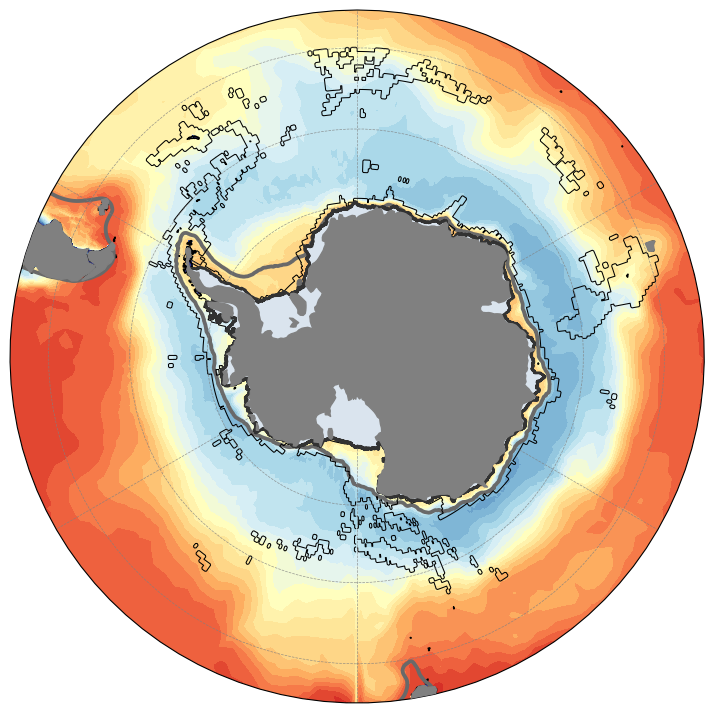

Map_pO2_1995-2014_COLORBAR
Colorbar png...


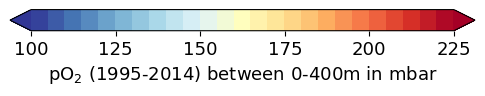

Colorbar eps...


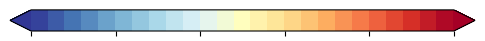

Plot ssp585
Map_pO2_ssp585_2091-2100_minus_1995-2014_depth_interval_between_0m_400m


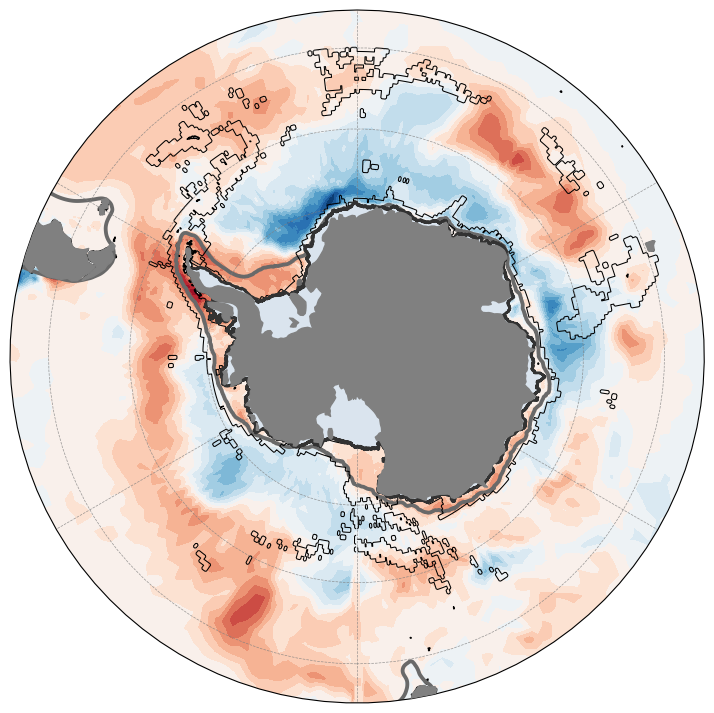

Map_pO2_2091-2100_minus_1995-2014_COLORBAR
Colorbar png...


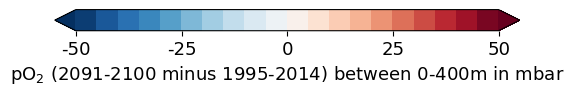

Colorbar eps...


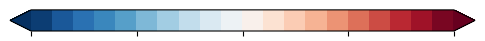

Plot ssp370
Map_pO2_ssp370_2091-2100_minus_1995-2014_depth_interval_between_0m_400m


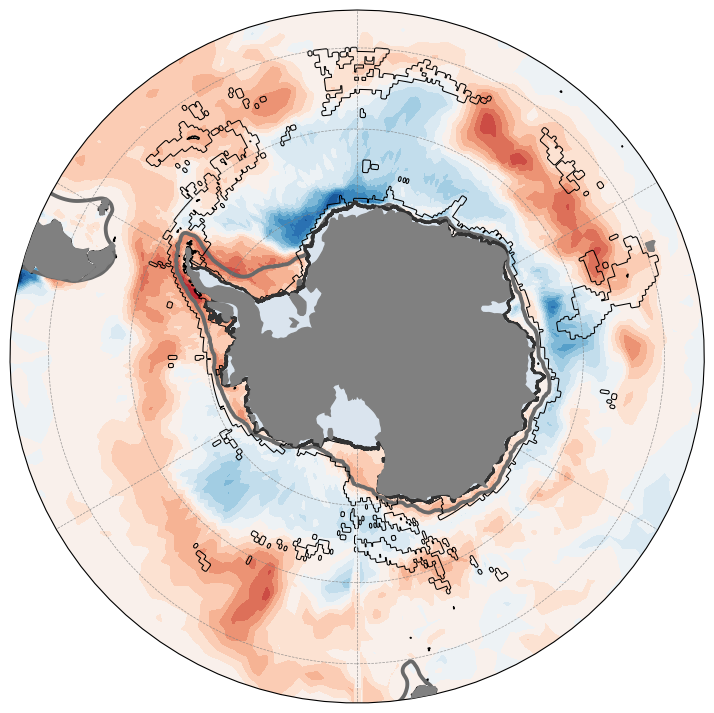

Plot ssp245
Map_pO2_ssp245_2091-2100_minus_1995-2014_depth_interval_between_0m_400m


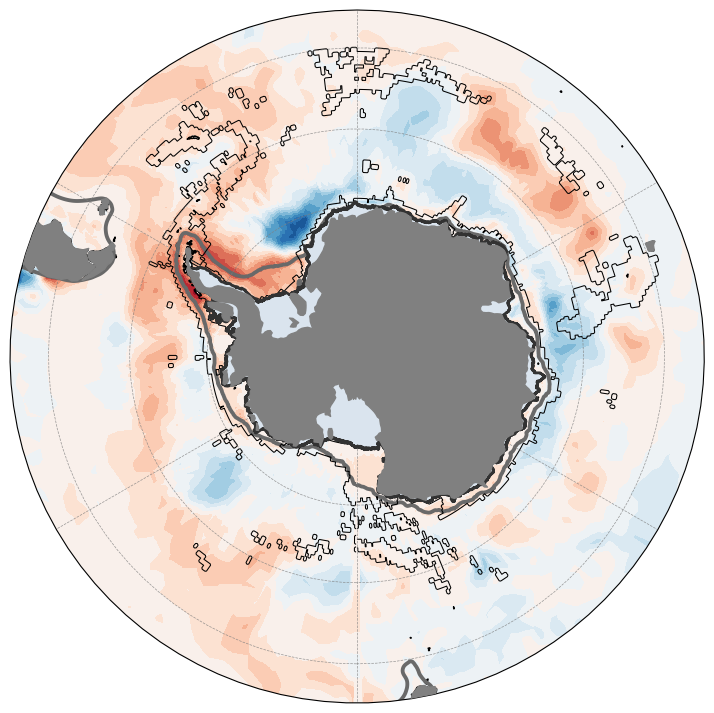

Plot ssp126
Map_pO2_ssp126_2091-2100_minus_1995-2014_depth_interval_between_0m_400m


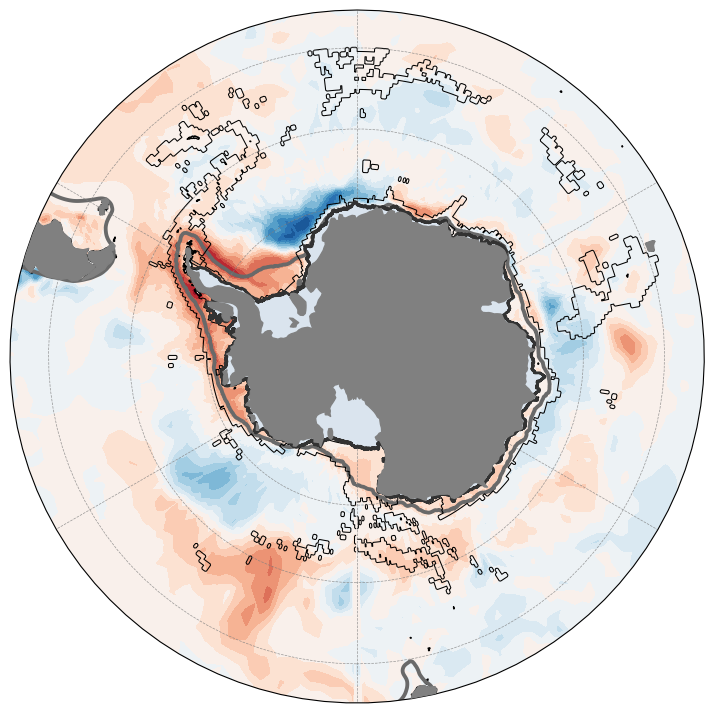


get average field between 400m and 700m


100%|██████████| 1440/1440 [01:32<00:00, 15.53it/s]


Min/max total_depth: 20.20001220703125 308.0

plot 1995-2014 and 2091-2100 minus 1995-2014...
Map_pO2_1995-2014_depth_interval_between_400m_700m


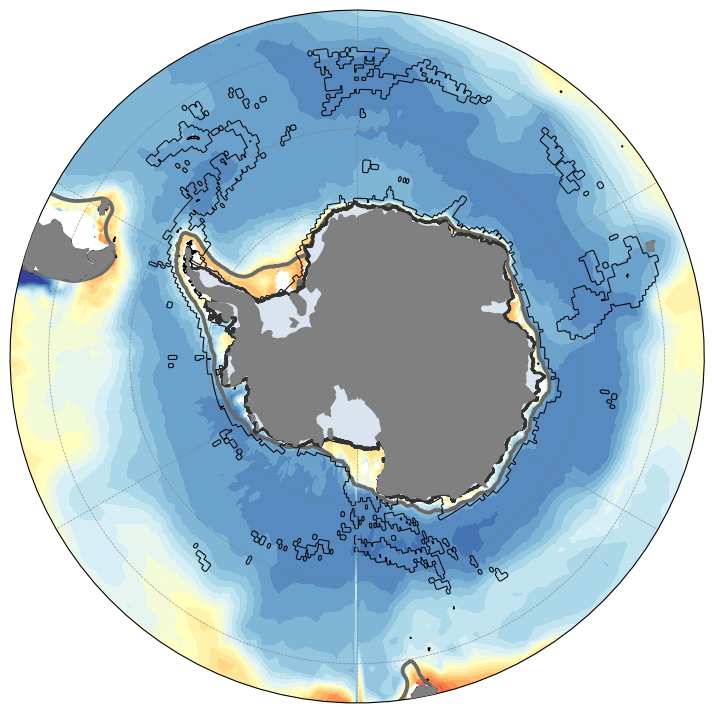

Plot ssp585
Map_pO2_ssp585_2091-2100_minus_1995-2014_depth_interval_between_400m_700m


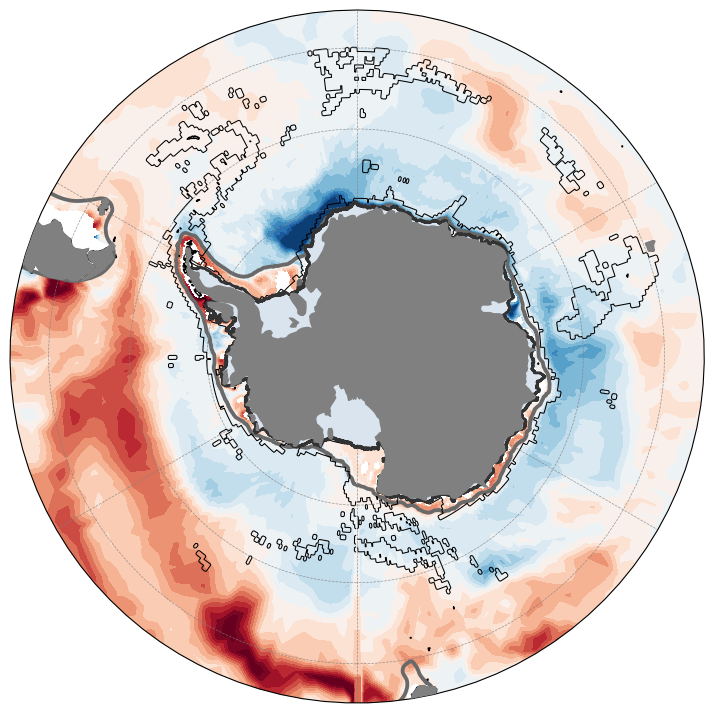

Plot ssp370
Map_pO2_ssp370_2091-2100_minus_1995-2014_depth_interval_between_400m_700m


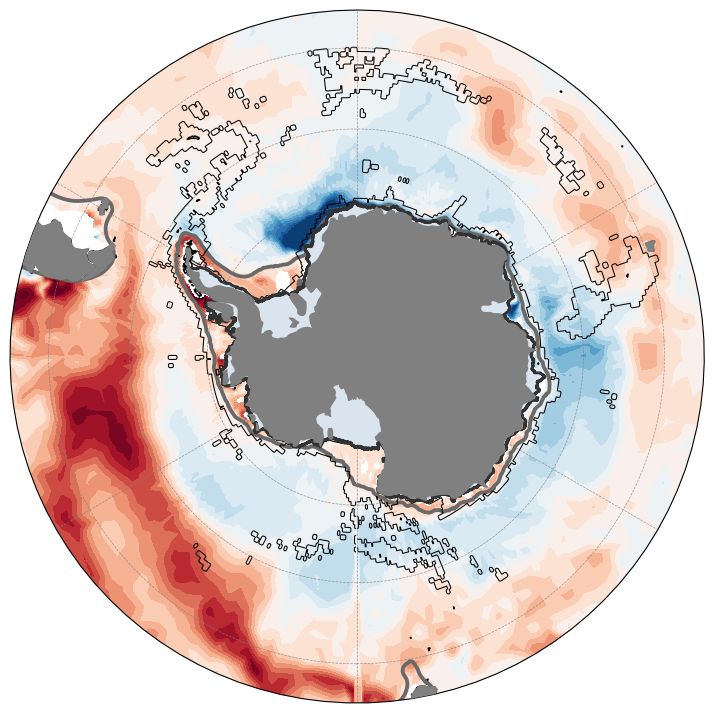

Plot ssp245
Map_pO2_ssp245_2091-2100_minus_1995-2014_depth_interval_between_400m_700m


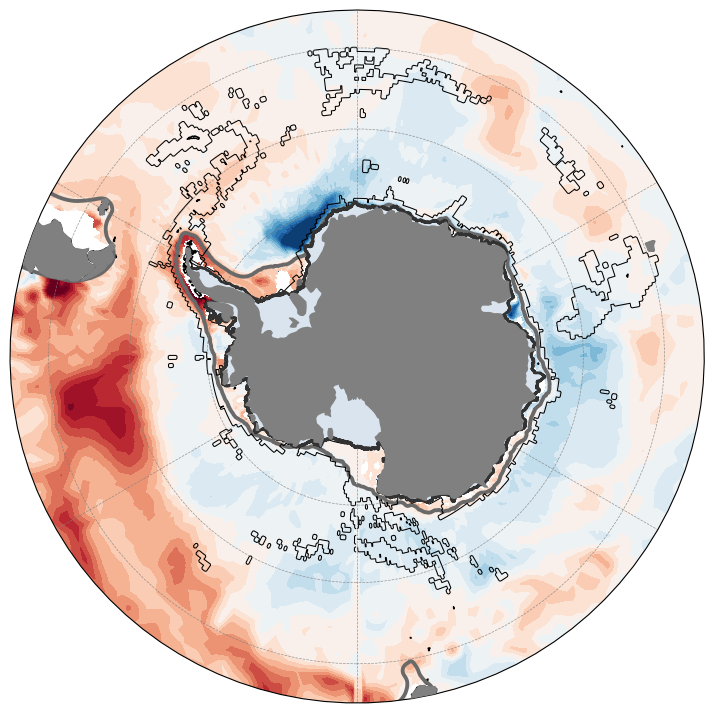

Plot ssp126
Map_pO2_ssp126_2091-2100_minus_1995-2014_depth_interval_between_400m_700m


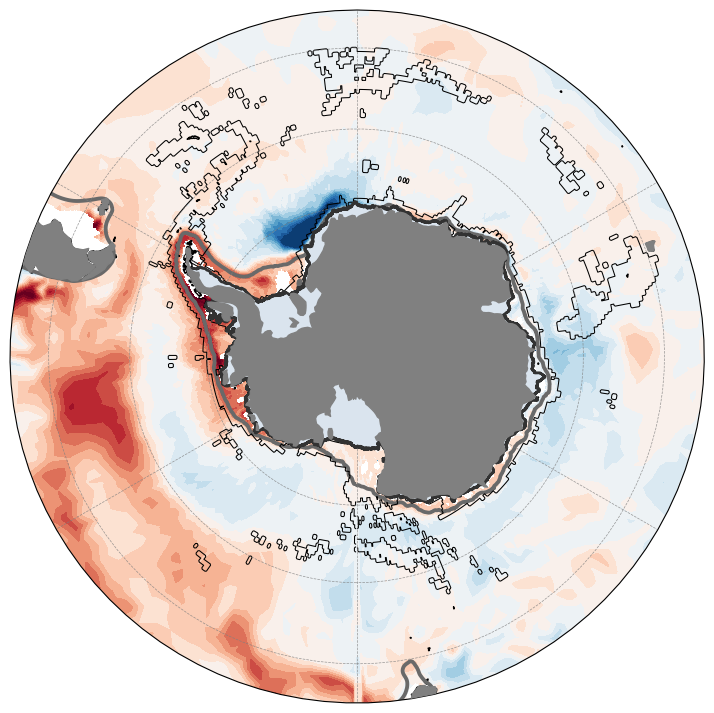


get average field between 700m and 1000m


100%|██████████| 1440/1440 [01:27<00:00, 16.40it/s]


Min/max total_depth: 21.20001220703125 278.29998779296875

plot 1995-2014 and 2091-2100 minus 1995-2014...
Map_pO2_1995-2014_depth_interval_between_700m_1000m


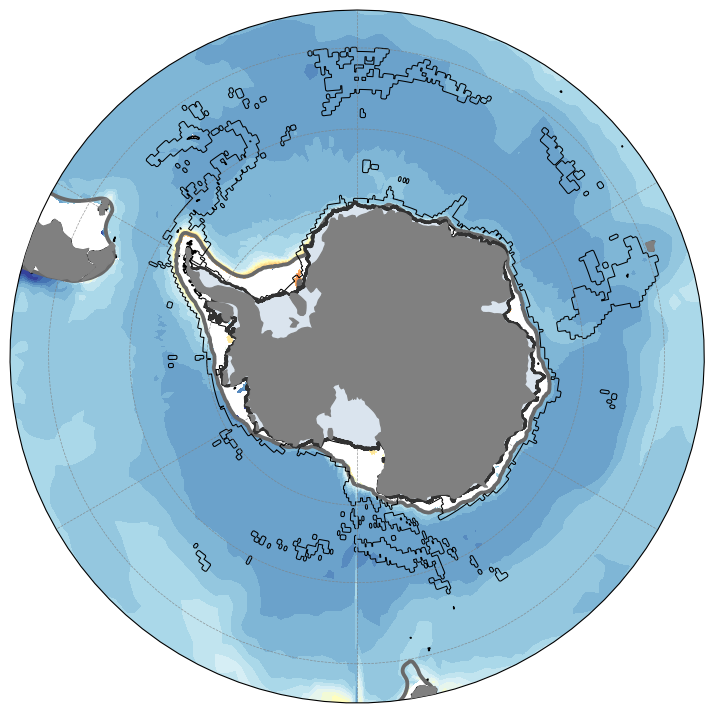

Plot ssp585
Map_pO2_ssp585_2091-2100_minus_1995-2014_depth_interval_between_700m_1000m


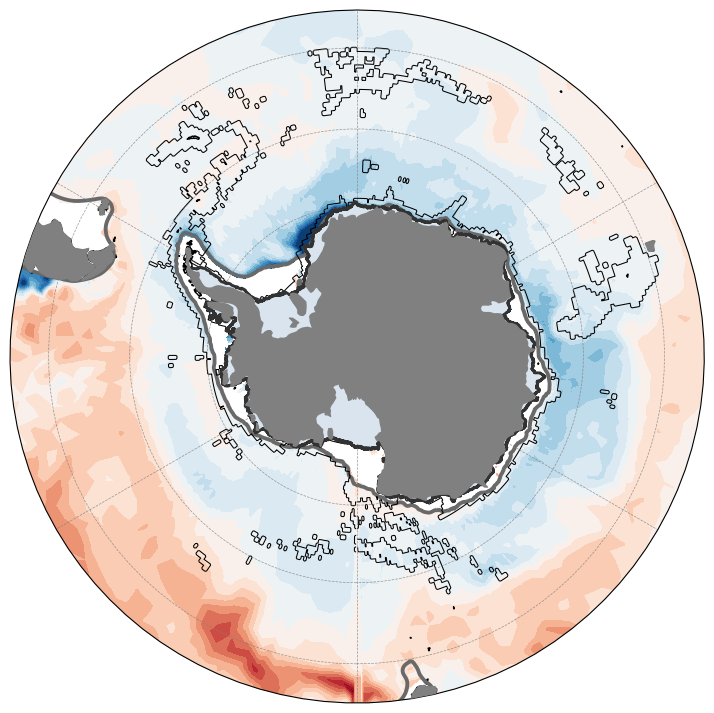

Plot ssp370
Map_pO2_ssp370_2091-2100_minus_1995-2014_depth_interval_between_700m_1000m


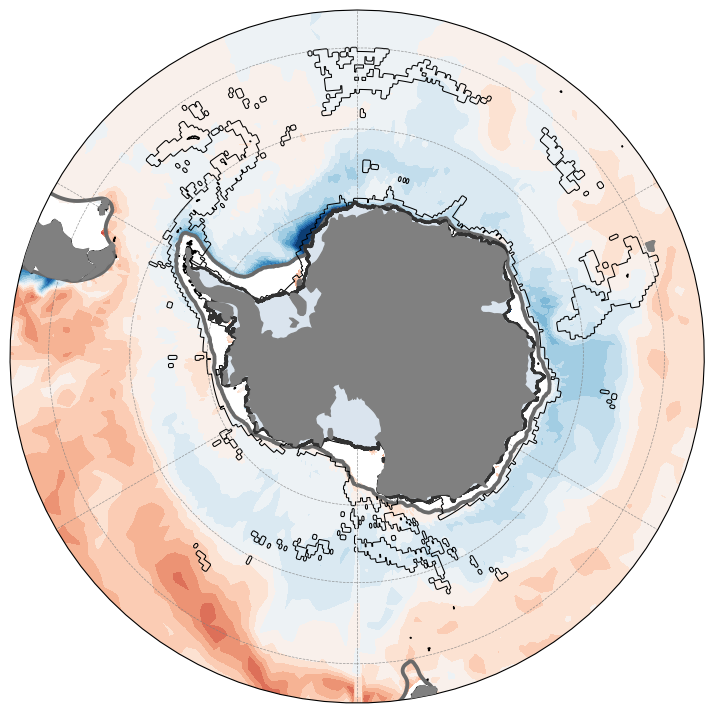

Plot ssp245
Map_pO2_ssp245_2091-2100_minus_1995-2014_depth_interval_between_700m_1000m


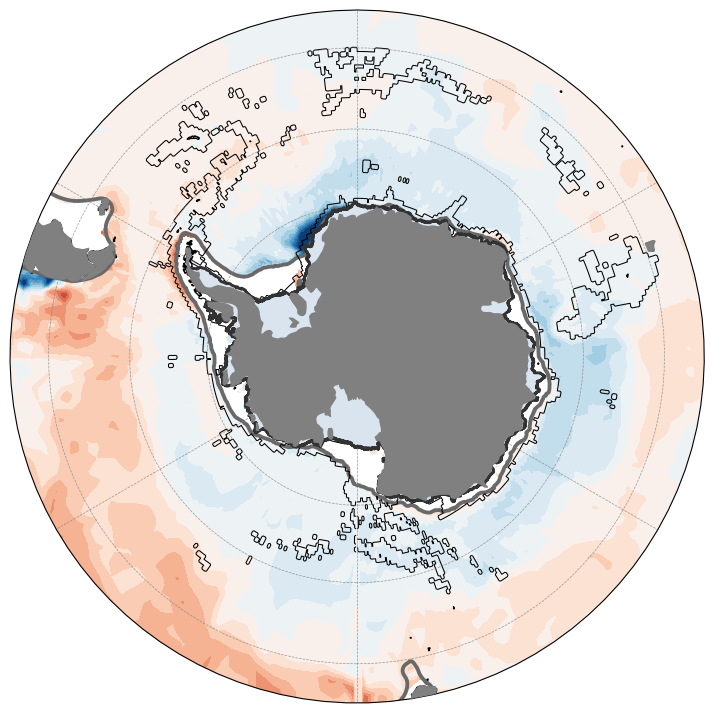

Plot ssp126
Map_pO2_ssp126_2091-2100_minus_1995-2014_depth_interval_between_700m_1000m


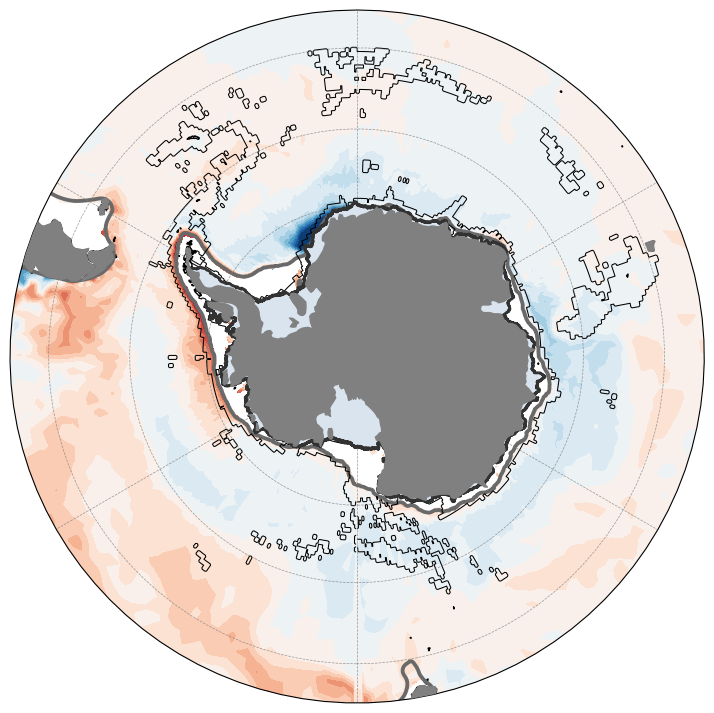

done


In [15]:
####
# 1) get average over current depth interval
# 2) interpolate
# 3) plot each depth interval
from tqdm import tqdm
from cartopy.util import add_cyclic_point

lat_orig,lon_orig = lat_model,lon_model 

save_plots = True
display_plots = True
to_plot = True

depths = np.copy(zlevs)

def interpolate_fields(lat_orig,lon_orig,data,lat_final,lon_final):
    interp_method = 'cubic' # cubic, nearest, linear
    data_int = griddata((lon_orig,lat_orig),data,\
                (lon_final.ravel(), lat_final.ravel()), method=interp_method)  # Final interpolated field
    data_int = data_int.reshape((lon_final.shape[0],lon_final.shape[1])) 
    return data_int
    
#---------
print ('regrid topo')
topo_int = interpolate_fields(lat_model,lon_model,topo,lat_agi_all,lon_agi_all) #y_all,x_all)
#--------
print ('regrid cavity info')
cav_int = interpolate_fields(lat_model,lon_model,cavities,lat_agi_all,lon_agi_all) #y_all,x_all)
#--------

ind_tf = species_names.index('Dissostichus mawsoni')

# second version of depth intervals (motivated by temp & O2 changes in toothfish habitat)
depth_list1 = [0,   0,  400,700, 1000]
depth_list2 = [3500,400,700,1000,3500]

time_String_hist   = '1995-2014'
time_String_future = str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))
time_String_diff   = str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))+' minus 1995-2014'
print(time_String_hist)
print(time_String_future)
print(time_String_diff)

data_avg_1990s   = np.zeros([len(depth_list1),len(lat_agi),len(lon_agi)])
data_avg_2090s_1 = np.zeros([len(depth_list1),len(lat_agi),len(lon_agi)])
data_avg_2090s_2 = np.zeros([len(depth_list1),len(lat_agi),len(lon_agi)])
data_avg_2090s_3 = np.zeros([len(depth_list1),len(lat_agi),len(lon_agi)])
data_avg_2090s_4 = np.zeros([len(depth_list1),len(lat_agi),len(lon_agi)])
for dd in range(1,4):#1,len(depth_list1)):
    print('')
    
    print('get average field between '+str(depth_list1[dd])+'m and '+str(depth_list2[dd])+'m')
    ind_dd = np.where((zlevs>=depth_list1[dd]) & (zlevs<depth_list2[dd]))[0]
    
    if depth_list1[dd]==0:
        # since zlevs are at the bottom of the cell, exclude zero here
        #dz = np.diff(zlevs[ind_dd])
        aux1 = np.copy(array_1990s_simA)[ind_dd,:,:]
        aux2 = np.copy(array_2090s)[ind_dd,:,:,0]
        aux3 = np.copy(array_2090s)[ind_dd,:,:,1]
        aux4 = np.copy(array_2090s)[ind_dd,:,:,2]
        aux5 = np.copy(array_2090s)[ind_dd,:,:,3]
    else:
        if depth_list2[dd]==3500:
            # for some reason, the code did not work if ind_dd contained 88... (why did it work before? CHECK)
            #dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[:-1]))]) 
            aux1 = np.copy(array_1990s_simA)[ind_dd[:-1],:,:]
            aux2 = np.copy(array_2090s)[ind_dd[:-1],:,:,0]
            aux3 = np.copy(array_2090s)[ind_dd[:-1],:,:,1]
            aux4 = np.copy(array_2090s)[ind_dd[:-1],:,:,2]
            aux5 = np.copy(array_2090s)[ind_dd[:-1],:,:,3]
        else:
            # add one before first index to correctly account for first depth level
            # (zlevs are at the bottom of the cell)
            #dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd))]) 
            aux1 = np.copy(array_1990s_simA)[ind_dd,:,:]
            aux2 = np.copy(array_2090s)[ind_dd,:,:,0]
            aux3 = np.copy(array_2090s)[ind_dd,:,:,1]
            aux4 = np.copy(array_2090s)[ind_dd,:,:,2]
            aux5 = np.copy(array_2090s)[ind_dd,:,:,3]

    #aux1 = np.copy(AGI_1)[ind_dd,:,:]
    #aux2 = np.copy(AGI_2)[ind_dd,:,:]
    
    # loop over all locations to create array with correct total_depth
    total_depth_all = np.zeros([aux1.shape[1],aux1.shape[2]])
    for mm in tqdm(range(0,aux1.shape[2])):
        for nn in range(0,aux1.shape[1]): 
            aux1b = aux1[:,nn,mm] # no need to also define aux2b -> NaNs in the vertical are identical across time slices
            aux1b[aux1b==0]=np.nan
            ind_av = np.where(~np.isnan(aux1b))[0]  
            if len(ind_av)>0: # only continue if any depth levels are available
                if depth_list1[dd]==0:
                    # CAREFULLY CHECK THIS!!!
                    if zlevs[ind_dd[ind_av]][0]>0:
                        # added for the case that only depth levels at the subsurface are available
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[ind_av]))]) 
                    else:
                        dz = np.diff(zlevs[np.hstack((0,ind_dd[ind_av]))]) # add an extra zero here so that field at 0m is not included
                        #dz = np.diff(zlevs[ind_dd[ind_av]])  
                else:
                    if depth_list2[dd]==3500:
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[:-1][ind_av]))]) 
                    else:
                        dz = np.diff(zlevs[np.hstack((ind_dd[0]-1,ind_dd[ind_av]))]) 
                #print(np.sum(dz),dz)

                # multiply AGI array with dz already
                aux1[ind_av,nn,mm] = aux1[ind_av,nn,mm]*np.abs(dz)
                aux2[ind_av,nn,mm] = aux2[ind_av,nn,mm]*np.abs(dz)
                aux3[ind_av,nn,mm] = aux3[ind_av,nn,mm]*np.abs(dz)
                aux4[ind_av,nn,mm] = aux4[ind_av,nn,mm]*np.abs(dz)
                aux5[ind_av,nn,mm] = aux5[ind_av,nn,mm]*np.abs(dz)

                total_depth_all[nn,mm] = np.sum(dz)
                
    aux1 = np.ma.masked_where(aux1==0,aux1)
    aux2 = np.ma.masked_where(aux2==0,aux2)
    aux3 = np.ma.masked_where(aux3==0,aux3)
    aux4 = np.ma.masked_where(aux4==0,aux4)
    aux5 = np.ma.masked_where(aux5==0,aux5)
    
    print('Min/max total_depth:',np.min(total_depth_all[total_depth_all>0]),np.max(total_depth_all))
    
    # AGI array has already been multiplied with dz above, simply sum up here and divide by the total depth
    data_avg_1990s[dd,:,:] = np.nansum(aux1,axis=0)/total_depth_all
    data_avg_2090s_1[dd,:,:] = np.nansum(aux2,axis=0)/total_depth_all
    data_avg_2090s_2[dd,:,:] = np.nansum(aux3,axis=0)/total_depth_all
    data_avg_2090s_3[dd,:,:] = np.nansum(aux4,axis=0)/total_depth_all
    data_avg_2090s_4[dd,:,:] = np.nansum(aux5,axis=0)/total_depth_all     
    
   #  #-----
  #  # regrid and plot (strictly speaking, the regridding is not necessary for plotting -> fields are already on a regular grid)
  #  # I do it anyways because the plotting function currently expects topo, cavity info and  and data to be on the same grid
  #  #-----
  #  print('')
  #  print('regrid field between '+str(depth_list1[dd])+'m and '+str(depth_list2[dd])+'m')
  #  
  #  #--------
  #  print('regrid 1990s')
  #  data_1990s_int = interpolate_fields(lat_model,lon_model,data_avg_1990s[dd,:], y_all,x_all)
  #  print('regrid 2090s')
  #  data_2090s_1_int = interpolate_fields(lat_model,lon_model,data_avg_2090s_1[dd,:], y_all,x_all)
  #  data_2090s_2_int = interpolate_fields(lat_model,lon_model,data_avg_2090s_2[dd,:], y_all,x_all)
  #  data_2090s_3_int = interpolate_fields(lat_model,lon_model,data_avg_2090s_3[dd,:], y_all,x_all)
  #  data_2090s_4_int = interpolate_fields(lat_model,lon_model,data_avg_2090s_4[dd,:], y_all,x_all)
  #  print('Min/Max 1990s:',np.nanmin(data_1990s_int),np.nanmax(data_1990s_int))
  #  print('Min/Max 2090s 1:',np.nanmin(data_2090s_1_int),np.nanmax(data_2090s_1_int))
  #  print('Min/Max 2090s 2:',np.nanmin(data_2090s_2_int),np.nanmax(data_2090s_2_int))
  #  print('Min/Max 2090s 3:',np.nanmin(data_2090s_3_int),np.nanmax(data_2090s_3_int))
  #  print('Min/Max 2090s 4:',np.nanmin(data_2090s_4_int),np.nanmax(data_2090s_4_int))
    
    
    #----
    # prepare data to plot
    #----
    data_topo = np.copy(topo_int)
    data_cav = np.copy(cav_int)

    # topo & sea ice
    def correct_dateline_points(data):
        # for topo & sea ice: correct a few more longitudes to get smooth contour lines across the dateline
        data[:,3] = data[:,4]
        data[:,2] = data[:,3]
        data[:,1] = data[:,2]
        data[:,0] = data[:,1]
        data[:,-4] = data[:,-5]
        data[:,-3] = data[:,-4]
        data[:,-2] = data[:,-3]
        data[:,-1] = data[:,-2]
        return data

    data_topo = correct_dateline_points(data_topo)

    data_cav[:,1] = data_cav[:,2]
    data_cav[:,0] = data_cav[:,1]
    data_cav[:,-2] = data_cav[:,-3]
    data_cav[:,-1] = data_cav[:,-2]

    data_1990s_int, lon   = add_cyclic_point(data_avg_1990s[dd,:,:], coord=lon_agi)# xi)
    data_2090s_1_int, lon = add_cyclic_point(data_avg_2090s_1[dd,:,:], coord=lon_agi)#xi)
    data_2090s_2_int, lon = add_cyclic_point(data_avg_2090s_2[dd,:,:], coord=lon_agi)#xi)
    data_2090s_3_int, lon = add_cyclic_point(data_avg_2090s_3[dd,:,:], coord=lon_agi)#xi)
    data_2090s_4_int, lon = add_cyclic_point(data_avg_2090s_4[dd,:,:], coord=lon_agi)#xi)
    lon_plot,lat_plot = np.meshgrid(lon,lat_agi) 

    data2, lonxx = add_cyclic_point(data_topo, coord=lon_agi)#xi)
    del lonxx
    data3, lonxx = add_cyclic_point(data_cav, coord=lon_agi)#xi)
    del lonxx
    #print (data2.shape)
    #print (data3.shape)

    #----
    # correct data in cavity etc
    #----
    # correct topo data on land
    data2[data2<0]=-999
    data2[np.isnan(data2)]=-999

    # cavity field
    data3[data3<0]=-999
    data3[np.isnan(data3)]=-999

    data2[data3>=0.5]=-999
    
    #---
    # plot difference 2090s-1990s
    #----
    print('')
    print ('plot '+time_String_hist+' and '+time_String_diff+'...')

    cmap1 = copy.copy(plt.cm.RdBu_r)
    cmap1.set_under('white')
    cmap2 = copy.copy(plt.cm.RdYlBu_r)
    if depth_list1[dd]>0:
        cmap2.set_under('white')
    cmap3 = copy.copy(plt.cm.RdBu_r) # without white
        
    levels1a = np.arange(100,225+5,5) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    cticks1 = [100,125,150,175,200,225]
    cticks_label = [100,125,150,175,200,225]
    
    #levels1a = np.arange(150,350+10,10) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    #cticks1 = [150,200,250,300,350]
    #cticks_label = [150,200,250,300,350]

    # 1990s (used to mask missing data for difference plot)
    data_plot = np.copy(data_1990s_int)
    if depth_list1[dd]>0: 
        data_plot[data_plot==0]=999
        data_plot[np.isnan(data_plot)]=999
        data_plot[data_plot<=levels1a[0]] = levels1a[0]+0.2
        data_plot[data_plot==999]=-999
    else:
        data_plot = np.ma.masked_where(data_plot==0,data_plot)
        data_plot = np.ma.masked_where(np.isnan(data_plot),data_plot)
        
    #data_plot[data_plot.mask==True] = -999 
    data_plot[data2<depth_list1[dd]] = -999 

    #data_plot[data_plot<=1]=-999
    #data_plot[data_plot>np.max(array_1990s_simA)]=-999
    #data_plot[data2<=depths[dd]]=-999

    clabel_string = 'pO$_{2}$ ('+time_String_hist+') between '+str(depth_list1[dd])+'-'+str(depth_list2[dd])+'m in mbar'
    depth_label = 'XX'
    filename = 'Map_pO2_'+time_String_hist+'_depth_interval_between_'+\
                        str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'
    print(filename)

    if to_plot:
        plot_map_circumpolar(data_plot,habitat_all[:,:,ind_tf],lon_plot,lat_plot,lon_tf,lat_tf,data2,\
                             levels1a,cmap2,cticks1,cticks_label,clabel_string,depth_label,\
                                        save_plots,display_plots,savepath,filename)
        if (dd==1):
            filename = 'Map_pO2_'+time_String_hist+'_COLORBAR' 
            print(filename)
            plot_map_circumpolar_colorbar(data_plot,lon_plot,lat_plot,data2,\
                             levels1a,cmap2,cticks1,cticks_label,clabel_string,depth_label,\
                                        save_plots,display_plots,savepath,filename)

            
    #----
    # PLOT ALL SCENARIOS!!!
    #----
    sim_list = ['ssp585','ssp370','ssp245','ssp126']
    levels1a = np.arange(-50,50+5,5) #np.arange(-100,100+10,10) #np.arange(-0.1,0.1+0.01,0.01)
    cticks1 = [-50,-25,0,25,50]
    cticks_label = [-50,-25,0,25,50]

    for ss in range(0,len(sim_list)):
        which_scenario = sim_list[ss]
        print('Plot',which_scenario)
        if which_scenario in ['ssp585']:
            aux_data_2090s = np.copy(data_2090s_1_int)
        elif which_scenario in ['ssp370']:
            aux_data_2090s = np.copy(data_2090s_2_int)
        elif which_scenario in ['ssp245']:
            aux_data_2090s = np.copy(data_2090s_3_int)
        elif which_scenario in ['ssp126']:
            aux_data_2090s = np.copy(data_2090s_4_int)
    
        data_plot2 = np.copy(aux_data_2090s - data_1990s_int) #data_plot_2090s_bottom-data_plot_1990s_bottom)
        data_plot2[data_plot2<levels1a[0]] = levels1a[0]+0.01
        data_plot2[data_plot<0]=-999
        del aux_data_2090s

        data_plot2[:,-1] = data_plot2[:,1]
        data_plot2[:,-2] = data_plot2[:,1]
        data_plot2[:,-3] = data_plot2[:,1]
        data_plot2[:,-4] = data_plot2[:,1]

        data_plot2[data2<depth_list1[dd]] = -999 

        clabel_string = 'pO$_{2}$ ('+time_String_diff+') between '+str(depth_list1[dd])+'-'+\
                            str(depth_list2[dd])+'m in mbar'
        depth_label = 'XX'
        filename = 'Map_pO2_'+which_scenario+'_'+time_String_diff.replace(" ","_")+'_depth_interval_between_'+\
                        str(depth_list1[dd])+'m_'+str(depth_list2[dd])+'m'      
        print(filename)

        plot_map_circumpolar(data_plot2,habitat_all[:,:,ind_tf],lon_plot,lat_plot,lon_tf,lat_tf,data2,\
                             levels1a,cmap1,cticks1,cticks_label,clabel_string,depth_label,\
                                      save_plots,display_plots,savepath,filename)

        if (dd==1) & (ss==0):
            filename = 'Map_pO2_'+time_String_diff.replace(" ","_")+'_COLORBAR' 
            print(filename)
            plot_map_circumpolar_colorbar(data_plot2,lon_plot,lat_plot,data2,\
                             levels1a,cmap3,cticks1,cticks_label,clabel_string,depth_label,\
                                        save_plots,display_plots,savepath,filename)
        
        del which_scenario,data_plot2
    
print('done')


In [ ]:
print(savepath)